TensorFlow Hub，一个用于迁移学习的库和平台。

随着越来越多的机器学习应用场景的出现，而现有表现比较好的监督学习需要大量的标注数据，标注数据是一项枯燥无味且花费巨大的任务，所以迁移学习受到越来越多的关注。

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [25]:
# dataset. imdb from tfds
train_data, val_data, test_data = tfds.load(name='imdb_reviews',
                                            split=('train[:60%]', 'train[60%:]', 'test'),
                                            as_supervised=True)

print(len(train_data), len(val_data), len(test_data))

Exception ignored in: <function CapturableResource.__del__ at 0x12f882280>
Traceback (most recent call last):
  File "/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/training/tracking/tracking.py", line 277, in __del__
    self._destroy_resource()
  File "/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 933, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 763, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3050, in _get_concrete_function_internal

15000 10000 25000


In [26]:
# 打印前 5 条评论+标签

reviews_batch, labels_batch = next(iter(train_data.batch(5)))

print(reviews_batch)

print(labels_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

2021-08-11 15:27:42.911263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


为了达到本教程的目的还有其他三种预训练模型可供测试：

google/tf2-preview/gnews-swivel-20dim-with-oov/1 ——类似 google/tf2-preview/gnews-swivel-20dim/1，但 2.5%的词汇转换为未登录词桶（OOV buckets）。如果任务的词汇与模型的词汇没有完全重叠，这将会有所帮助。
google/tf2-preview/nnlm-en-dim50/1 ——一个拥有约 1M 词汇量且维度为 50 的更大的模型。
google/tf2-preview/nnlm-en-dim128/1 ——拥有约 1M 词汇量且维度为128的更大的模型。

In [27]:
# 将文本转化为嵌入向量（使用 TF hub 的预训练文本嵌入（text embedding）模型）
embedding = "../download/tf2-preview_gnews-swivel-20dim_1"
hub_layer = hub.KerasLayer(embedding,
                           input_shape=[],
                           dtype=tf.string,
                           trainable=True)

print(hub_layer(reviews_batch[:3]))

tf.Tensor(
[[ 1.765786   -3.882232    3.9134233  -1.5557289  -3.3362343  -1.7357955
  -1.9954445   1.2989551   5.081598   -1.1041286  -2.0503852  -0.72675157
  -0.65675956  0.24436149 -3.7208383   2.0954835   2.2969332  -2.0689783
  -2.9489717  -1.1315987 ]
 [ 1.8804485  -2.5852382   3.4066997   1.0982676  -4.056685   -4.891284
  -2.785554    1.3874227   3.8476458  -0.9256538  -1.896706    1.2113281
   0.11474707  0.76209456 -4.8791065   2.906149    4.7087674  -2.3652055
  -3.5015898  -1.6390051 ]
 [ 0.71152234 -0.6353217   1.7385626  -1.1168286  -0.5451594  -1.1808156
   0.09504455  1.4653089   0.66059524  0.79308075 -2.2268345   0.07446612
  -1.4075904  -0.70645386 -1.907037    1.4419787   1.9551861  -0.42660055
  -2.8022065   0.43727064]], shape=(3, 20), dtype=float32)


2021-08-11 15:27:42.942815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-11 15:27:42.954138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [28]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=40,
                    validation_data=val_data.batch(512),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 62ms/step - loss: 0.5526 - accuracy: 0.7202 - val_loss: 0.5570 - val_accuracy: 0.7182

In [34]:
results = model.evaluate(test_data.batch(512), verbose=1)


49/49 [==============================] - 1s 25ms/step - loss: 0.5578 - accuracy: 0.7176

画图

In [35]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

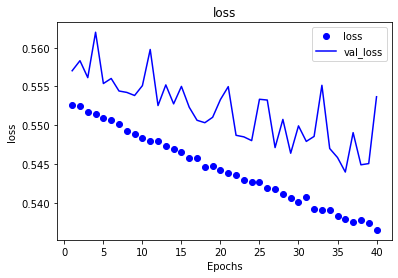

In [37]:
import matplotlib.pyplot as plt

plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, 'bo', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.legend()
plt.show()

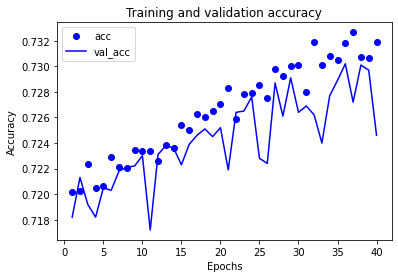

In [38]:
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()
plt.show()
